In [ ]:
!wget -O data.zip https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
!unzip data.zip

--2023-04-30 05:48:47--  https://www.dropbox.com/s/bcrs90kyytjph42/cifar-10-batches-py.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip [following]
--2023-04-30 05:48:47--  https://www.dropbox.com/s/raw/bcrs90kyytjph42/cifar-10-batches-py.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0238f142fc50ca2b63df86af8b.dl-eu.dropboxusercontent.com/cd/0/inline/B7INdjfTlSaXwGCKdjNHC10BLTYd2eHAXQmSsNUMTjtUkMYX_QZ94sR-7NeL2riC16GY6ni0kvG3qmEacA8emcavK1XMvvPGBw7K_TmVFDReWOUMbSF8qA-RAA6YxMED27uoCm7uS7jYE5LVbIvnHSQs8Avz-cYA8sKVAuyD8p_Qgg/file# [following]
--2023-04-30 05:48:47--  https://uc0238f142fc50ca2b63df86af8b.dl-eu.dropboxusercontent.com/cd/0/inline/B7INdjfTlSaXwGCKdjNHC10BLTYd2eHAX

#Data Loading


In [ ]:
#Notice that train data has 5 batches. below code can be used
#to read the train data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
!ls cifar-10-batches-py


batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as imo
import os
import pandas as pd

In [ ]:
batch1 = unpickle("cifar-10-batches-py/data_batch_1")



In [ ]:
class NormalZipper(Dataset):

  def __init__(self,batch_path = "cifar-10-batches-py"):
    self.images = []
    self.labels = []
    for batch_number in range(1,6):
      dict_ = unpickle(f"{batch_path}/data_batch_{batch_number}")
    self.images = dict_[b"data"]
    self.labels = dict_[b"labels"]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    im = self.images[idx,:]
    label = self.labels[idx]
    im = np.reshape(im,(3,32,32))
    
    return (im,label)

In [ ]:
class CsvZipper(Dataset):
  def __init__(self,path_csv):
    self.data = pd.read_csv(path_csv).to_numpy()
    self.images = self.data[0:,:]
    self.labels = self.data[0,:]


  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self,idx):
    im = self.images[idx,:]
    im = np.reshape(im,(3,32,32))/255
    
    return (im)

In [ ]:
data = NormalZipper()
test = CsvZipper("cifar-10-batches-py/test.csv")
len(data)

10000

In [ ]:
train_loader = DataLoader(data,batch_size=64)

In [ ]:
t1 = iter(train_loader)
batch=next(t1)
batch[0].shape

torch.Size([64, 3, 32, 32])

torch.Size([64, 3, 32, 32])


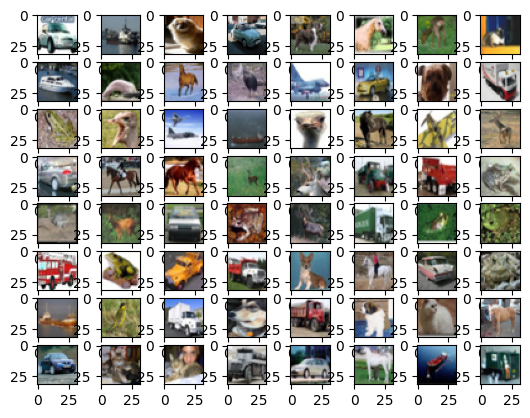

In [ ]:
train_loader = DataLoader(data,batch_size = 64)

tl = iter(train_loader)
batch = next (tl)
print(batch[0].shape)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[0][i,:,:,:].permute(1, 2, 0))

#Training 

In [ ]:
class MyCNN(nn.Module):
  def __init__(self):
   # conv pool bn drop out
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
     
    self.bn1 = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(16,32, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(64)

    self.linear1 = nn.Linear(32*32*64 , 100)
    self.linear2 = nn.Linear(100, 10)

  def forward(self,x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))
    x = x.view(-1, 64 * 32 * 32)

    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x


    
    

In [ ]:
net =  MyCNN()
net


MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=65536, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

Adjusting learning rate of group 0 to 2.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 2.5000e-03.
Adjusting learning rate of group 0 to 1.2500e-03.
Adjusting learning rate of group 0 to 6.2500e-04.
Adjusting learning rate of group 0 to 3.1250e-04.
Adjusting learning rate of group 0 to 1.5625e-04.
Adjusting learning rate of group 0 to 7.8125e-05.
Adjusting learning rate of group 0 to 3.9063e-05.
Adjusting learning rate of group 0 to 1.9531e-05.


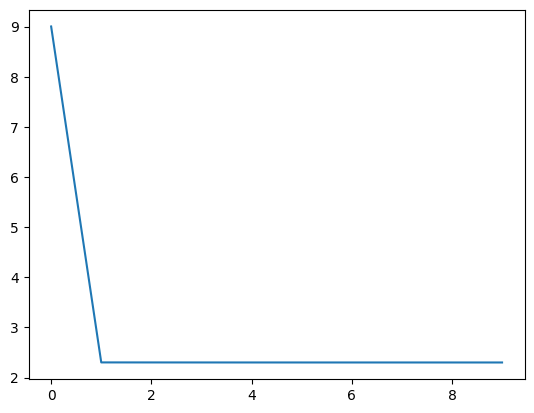

In [ ]:
device= torch.device("cuda:0")
net.to(device)
optimizer = optim.Adam(net.parameters(), lr= 0.02)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
num_epocs = 10
ls = []
for i in range(num_epocs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].type(torch.FloatTensor).to(device), batch[1].to(device)
    
    logits = net(X)
    
    loss = F.cross_entropy(logits,y)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
plt.plot(ls)
